In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [160]:
df = pd.read_csv('Github_Indian_Users_Deep_Data.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.shape


(10122, 15)

Stage: Cleanup and EDA

In [161]:
del df['name'] # Name is redundant username is sufficient
df.head()
df.isnull().sum()

username                     39
joining_year                 26
repositories                 52
last_year_contributions      52
achievements_num             52
stars                        52
followers                    52
followings                 2949
has_readme                   52
works_for                  6641
status                     5902
location                     52
language                     52
gender_pronoun             6980
dtype: int64

Replace NaN values with appropriate values

In [162]:
df['gender_pronoun'].unique()
#df['joining_year'].unique()


array(['he/him', nan, 'Gentleman/Wiseman', 'she/her', 'they/them',
       'PhD (Mathematics)', 'Techie', 'The one', '?V', 'Shivam',
       'bit/bits', 'Little Codr', 'ShaksZ', 'phenol', 'He/Him', 'Him',
       'Just a Tech', 'Go/TypeScript/Powershell', 'He/Him/His',
       'You can do it ?', 'Nayeem', 'SSL/SSO', 'Σ', 'Mr.', 'coder',
       'bro/bhai', 'Batman/Bateman', 'if/else', 'he', 'Thar/kuri',
       'bat/man', 'Mritunjay Kumar', 'roro', 'insaan', 'she/her/they',
       'Pengwin/Penglose', 'MR', 'Arch BTW', 'Mr', 'Nanya',
       'White Power Ranger', 'Attack Helicopter', 'Rocket/Raccoon',
       'CodeholiC', 'Developer', 'He/Him • Programmer + Gamer',
       'King/God', '~Hack3r_Oneness is Active on Internet'], dtype=object)

In [163]:
unknown_for_na_columns = ['username', 'works_for', 'status', 'location', 'language']
for col in unknown_for_na_columns:
    df[col].fillna('unknown', inplace=True)
zero_for_na_columns = ['repositories', 'last_year_contributions', 'achievements_num', 'stars', 'followers', 'followings']   
for col in zero_for_na_columns:
    df[col].fillna(0, inplace=True) 
df['joining_year'].fillna(2024, inplace=True)
df['joining_year'] = df['joining_year'].apply(lambda x: 2024 if isinstance(x, str) else x)
df['joining_year'] = df['joining_year'].replace(r'^\s*$', 2024, regex=True)
df['has_readme'].fillna('FALSE', inplace=True)
df['gender_pronoun'].fillna('they/them', inplace=True)
df.isnull().sum()


username                   0
joining_year               0
repositories               0
last_year_contributions    0
achievements_num           0
stars                      0
followers                  0
followings                 0
has_readme                 0
works_for                  0
status                     0
location                   0
language                   0
gender_pronoun             0
dtype: int64

In [164]:

# If there are any other variations of True/False (e.g., 'true', 'false'), handle them as well:
df['has_readme'] = df['has_readme'].replace('FALSE', 0)
df['has_readme'] = df['has_readme'].replace('TRUE', 1)
print(df['has_readme'].head())
# Now, convert to integer
df['has_readme'] = df['has_readme'].astype(int)

# Check the result
print(df['has_readme'].head())

0    False
1     True
2     True
3    False
4    False
Name: has_readme, dtype: object
0    0
1    1
2    1
3    0
4    0
Name: has_readme, dtype: int64


See Distribution

In [165]:
print(df['followers'].describe())
count = df[(df['followers'] == 0) | (df['followers'] == 1)].shape[0]
print(f"Count of rows where followers are 0 or 1: {count}")

count    10122.000000
mean        11.123592
std        119.899554
min          0.000000
25%          0.000000
50%          1.000000
75%          6.000000
max       8800.000000
Name: followers, dtype: float64
Count of rows where followers are 0 or 1: 5615


In [166]:
print(df['stars'].describe())
count = df[(df['stars'] == 0) | (df['stars'] == 1)].shape[0]
print(f"Count of rows where stars are 0 or 1: {count}")

count    10122.000000
mean        20.844497
std        102.675282
min          0.000000
25%          0.000000
50%          2.000000
75%         10.000000
max       3400.000000
Name: stars, dtype: float64
Count of rows where stars are 0 or 1: 4967


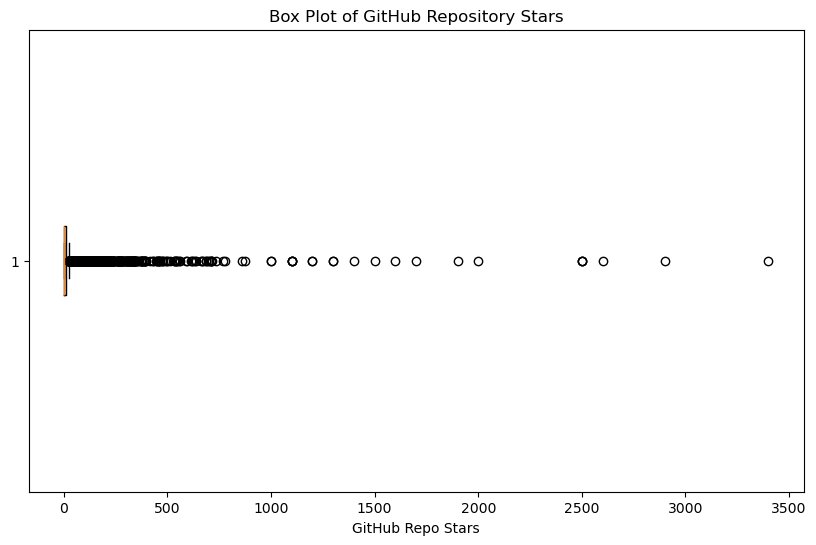

In [167]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['stars'], vert=False)
plt.title("Box Plot of GitHub Repository Stars")
plt.xlabel("GitHub Repo Stars")
plt.show()

In [168]:
count = df[(df['stars'] >= 0) & (df['stars'] <= 1000)].shape[0]
print(f"Count of rows where stars are between 0 to 1000: {count}")
count = df[(df['stars'] >= 1000) & (df['stars'] <= 2000)].shape[0]
print(f"Count of rows where stars are between 1000 to 2000: {count}")
count = df[(df['stars'] >= 2000) & (df['stars'] <= 3000)].shape[0]
print(f"Count of rows where stars are between 2000 to 3000: {count}")
count = df[(df['stars'] >= 3000) & (df['stars'] <= 3500)].shape[0]
print(f"Count of rows where stars are between 3000 to 3500: {count}")

Count of rows where stars are between 0 to 1000: 10102
Count of rows where stars are between 1000 to 2000: 16
Count of rows where stars are between 2000 to 3000: 6
Count of rows where stars are between 3000 to 3500: 1


In [169]:
# Remove outliers with very large values 
df = df[~((df['stars'] > 1000) & (df['stars'] <= 3500))].reset_index(drop=True)
df.shape

(10102, 14)

In [170]:
# Remove values 0 and 1 for now which are greatly unbalancing data 
df = df[(df['stars'] > 1)].reset_index(drop=True)
df.shape
df.head

<bound method NDFrame.head of              username  joining_year  repositories  last_year_contributions  \
0         infysumanta          2024         445.0                    623.0   
1     codingwithkrish          2024          37.0                    204.0   
2       EngageTrooper          2024          12.0                      0.0   
3        yashjain0112          2024          25.0                      0.0   
4             StarTwi          2024          11.0                      2.0   
...               ...           ...           ...                      ...   
5130        abdaahads          2024           9.0                      9.0   
5131       code-arpit          2024          30.0                    711.0   
5132  patel-rupin2000          2024          35.0                     33.0   
5133       jha-hitesh          2024          17.0                      5.0   
5134      therohitdas          2024          20.0                    278.0   

      achievements_num  stars  fo

In [171]:
# Define the characters to check for
invalid_chars = ["[", "]", "<"]

# Filter rows to keep only those without any of the invalid characters in any feature column
df = df[~df.apply(lambda row: any(char in str(row[col]) for col in df.columns for char in invalid_chars), axis=1)]


Feature importnace

In [172]:
df.columns



Index(['username', 'joining_year', 'repositories', 'last_year_contributions',
       'achievements_num', 'stars', 'followers', 'followings', 'has_readme',
       'works_for', 'status', 'location', 'language', 'gender_pronoun'],
      dtype='object')

In [173]:

from sklearn.metrics import mutual_info_score
categorical = ['username', 'works_for', 'status',	'location',	'language',	'gender_pronoun']
numerical = ['has_readme', 'repositories', 'last_year_contributions',	'achievements_num',	'followers', 'followings']	
#mutual_info_score(df.has_readme, df.stars)
def mutual_info_stars_score(series):
    return mutual_info_score(series, df.stars)
mi = df[categorical].apply(mutual_info_stars_score)
mi.sort_values(ascending=False)

username          3.987734
works_for         1.518930
location          1.343264
status            1.037394
gender_pronoun    0.082300
language          0.075657
dtype: float64

In [174]:
df[numerical].corrwith(df.stars).abs()

has_readme                 0.046432
repositories               0.278178
last_year_contributions    0.216872
achievements_num           0.317428
followers                  0.139723
followings                 0.128480
dtype: float64

In [175]:
#joining_year = ['joining_year']
#df[joining_year].corrwith(df.stars).abs()

Stage: Model Training 

Split data into train validation and test

In [176]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(3075, 1025, 1025)

In [177]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.stars.values
y_val = df_val.stars.values
y_test = df_test.stars.values

del df_train['stars']
del df_val['stars']
del df_test['stars']

One-hot encoding

In [178]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=True)




train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
#dv.feature_names_

Training linear regression

In [179]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

3.751039433041991

In [180]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)

    return y_pred

In [181]:
dv, model = train(df_train, y_train)
y_pred =  predict(df_val, dv, model)
mean_squared_error(y_val, y_pred, squared=False)

70.44206399419326

In [182]:
# from sklearn.model_selection import KFold
# n_splits = [3, 5, 10, 15, 20, 100, 200, 250]
# for n_split in n_splits: 
#     kfold = KFold(n_splits=n_split, shuffle=True, random_state=1)
#     for train_idx, val_idx in kfold.split(df_full_train):
#         df_train = df_full_train.iloc[train_idx]
#         df_val = df_full_train.iloc[val_idx]

#         y_train = df_train.stars.values
#         y_val = df_val.stars.values

#         dv, model = train(df_train, y_train)
#         y_pred = predict(df_val, dv, model)

#     print(mean_squared_error(y_val, y_pred, squared=False))
    

In [183]:
df['stars'].describe()

count    5125.000000
mean       33.856390
std        78.191992
min         2.000000
25%         4.000000
50%        10.000000
75%        28.000000
max      1000.000000
Name: stars, dtype: float64

Training random forest regressor


In [184]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False).round(3)

27.375

In [185]:
# scores = []
# for n in range(10, 201, 10):
#     rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
#     rf.fit(X_train, y_train)

#     y_pred = rf.predict(X_val)
#     rmse = mean_squared_error(y_val, y_pred, squared=False).round(3)
    
#     scores.append((n, rmse))

In [186]:
# print(scores)

In [187]:
scores = []
for d in [10, 5, 3, 1]:    
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False).round(3)
        
        scores.append((n, rmse))
        df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
    print(df_scores['rmse'].mean())

68.34585
68.72695
69.01266666666668
69.64236249999999


XGBoost

In [188]:
import xgboost as xgb
features = list(dv.get_feature_names_out())
print(len(features))
for feature in features:
    if "[" in feature or "]" in feature or "<" in feature:
        print(feature)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

5567


In [189]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [190]:
y_pred = model.predict(dval)
mean_squared_error(y_val, y_pred, squared=False).round(3)

69.05